# Analyzing NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, scikit-learn, and Dask.

The New York City Taxi and Limousine Commission provides (anonymized) data on all of the trips taken in New York as a series of Parquet files.

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), find interesting patterns in the data, and build a simple predictive model on top of it.

In [1]:
import glob
import os
import requests

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import cudf
import cuml

/home/ashwin/miniconda3/envs/all_cuda-118_arch-x86_64/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Getting the data

In [2]:
def download(url, fname):
    """
    Download file from `url`, writing the result to `fname`.
    If `fname` already exists, do nothing.
    """
    # this code adapted from the tqdm examples
    # https://github.com/tqdm/tqdm/blob/master/examples/tqdm_requests.py
    if os.path.exists(fname):
        return
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(
        open(fname, "wb"), "write",
        unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
        desc=fname, total=int(response.headers.get('content-length', 0))
    ) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)

def download_taxi_data():
    base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
    fname = "yellow_tripdata_2021-{i:02d}.parquet"
    url = base + fname
    for i in range(1, 13):  # 12 months of data
        download(url.format(i=i), fname.format(i=i))
    
def download_taxi_zones():
    download(
        "https://raw.githubusercontent.com/shwina/rapids-tutorial-gtc-2023/master/taxi_zones.csv?token=GHSAT0AAAAAAB4LHVK6US5ICH2ZZMTAVXMUY7YAMHQ",
        "taxi_zones.csv"
    )
    
download_taxi_data()
download_taxi_zones()

In [12]:
df = pd.read_parquet('yellow_tripdata_2021-01.parquet')
display(df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,NaN,8.89,NaN,None,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,NaN,NaN
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,NaN,7.43,NaN,None,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,NaN,NaN
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,NaN,6.26,NaN,None,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,NaN,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,None,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,NaN,NaN


In [13]:
%%time
# TODO: Read the CSV with cudf into gdf

gdf = cudf.read_parquet('yellow_tripdata_2021-01.parquet')
display(gdf)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,<NA>
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,<NA>
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,<NA>
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,<NA>
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,<NA>,8.89,<NA>,<NA>,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,<NA>,<NA>
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,<NA>,7.43,<NA>,<NA>,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,<NA>,<NA>
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,<NA>,6.26,<NA>,<NA>,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,<NA>,<NA>
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,<NA>,19.70,<NA>,<NA>,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,<NA>,<NA>


CPU times: user 338 ms, sys: 65.7 ms, total: 404 ms
Wall time: 360 ms


# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

1. First, we want to work with just a subset of columns
2. We want to eemove any extraneous spaces from column names and change them to all lowercase
3. We'll cast columns to the appropriate data types (using 32-bit data types where possible for speed and memory efficiency)
3. For simplicity, we'll replace missing values ("nulls") with a sentinel value -1

In [14]:
# list of column names that need to be re-mapped
remap = {
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'ratecodeid': 'rate_code',
    'pulocationid': 'pickup_location',
    'dolocationid': 'dropoff_location'
}

# create a list of columns & dtypes the df must have
# note that float64 will be significantly slower on some GPUs (most GeForce, also Tesla T4)
must_haves = {
    'pickup_datetime': 'datetime64[ms]',
    'dropoff_datetime': 'datetime64[ms]',
    'passenger_count': 'int32',
    'trip_distance': 'float',
    'pickup_longitude': 'float',
    'pickup_latitude': 'float',
    'rate_code': 'int32',
    'dropoff_longitude': 'float',
    'dropoff_latitude': 'float',
    'fare_amount': 'float',
    'pickup_location': 'int32',
    'dropoff_location': 'int32',
    ## Ashwin: Added these
    'is_credit_card': 'int',
    'airport_fee': 'float'
}

# helper function which takes a DataFrame and fixes column types
def clean_columns(df, remap, must_haves):  
    # rename columns
    col_cleanup = {col: col.strip().lower() for col in df.columns}
    df = df.rename(columns=col_cleanup)
    df = df.rename(remap, axis=1)

    # Simplify the payment_type column
    df["is_credit_card"] = df["payment_type"] == 1

    for col in df.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            print(f"Dropping ({col})")
            df = df.drop(columns=col)
            continue
        if df[col].dtype.kind in {'i', 'f'}:
            df[col] = df[col].fillna(-1)
        df[col] = df[col].astype(must_haves[col])
        
    
    return df

In [15]:
%%time
# Pandas approach

# some col-names include pre-pended spaces remove & lowercase column names
# rename columns using the supplied mapping

df = clean_columns(df, remap, must_haves)
print(df.__class__)
display(df)

Dropping (vendorid)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
<class 'pandas.core.frame.DataFrame'>


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.00,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.00,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.00,-1.0,1
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,138,132,29.00,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.50,-1.0,1
...,...,...,...,...,...,...,...,...,...,...
1369764,2021-01-31 23:03:00,2021-01-31 23:33:00,-1,8.89,-1,229,181,27.78,-1.0,0
1369765,2021-01-31 23:29:00,2021-01-31 23:51:00,-1,7.43,-1,41,70,32.58,-1.0,0
1369766,2021-01-31 23:25:00,2021-01-31 23:38:00,-1,6.26,-1,74,137,16.85,-1.0,0
1369767,2021-01-31 23:01:06,2021-02-01 00:02:03,-1,19.70,-1,265,188,53.68,-1.0,0


CPU times: user 502 ms, sys: 168 ms, total: 670 ms
Wall time: 659 ms


In [16]:
%%time
# TODO: RAPIDS approach - same as aPandas, but generate 'gdf' as output

gdf = clean_columns(gdf, remap, must_haves)
print(gdf.__class__)
display(gdf)

Dropping (vendorid)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
<class 'cudf.core.dataframe.DataFrame'>


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.00,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.00,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.00,-1.0,1
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,138,132,29.00,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.50,-1.0,1
...,...,...,...,...,...,...,...,...,...,...
1369764,2021-01-31 23:03:00,2021-01-31 23:33:00,-1,8.89,-1,229,181,27.78,-1.0,0
1369765,2021-01-31 23:29:00,2021-01-31 23:51:00,-1,7.43,-1,41,70,32.58,-1.0,0
1369766,2021-01-31 23:25:00,2021-01-31 23:38:00,-1,6.26,-1,74,137,16.85,-1.0,0
1369767,2021-01-31 23:01:06,2021-02-01 00:02:03,-1,19.70,-1,265,188,53.68,-1.0,0


CPU times: user 77.7 ms, sys: 48.3 ms, total: 126 ms
Wall time: 134 ms


# Look at some key stats

We'll plot the data using the Seaborn library, which you can install via `pip install seaborn`. For a more general guide on how to use RAPIDS with most of the popular visualization libraries, see the viz gallery in our docs: https://docs.rapids.ai/visualization

In [17]:
import seaborn as sns

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

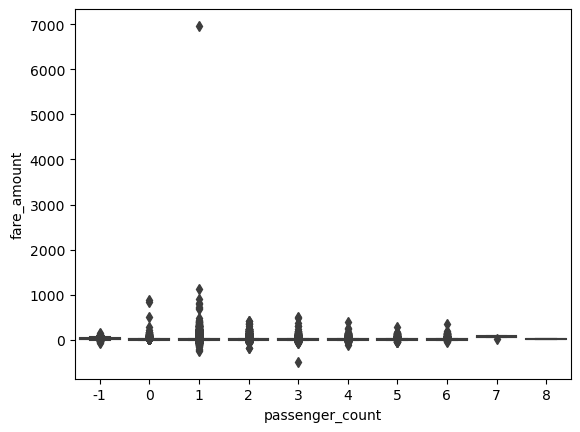

In [18]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

# Filter the data

In [19]:
%%time

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
df = df.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
display(df)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...
1271412,2021-01-31 23:58:47,2021-02-01 00:04:40,3,0.81,1,41,74,5.0,-1.0,0
1271413,2021-01-31 23:07:54,2021-01-31 23:19:42,1,3.81,1,113,141,12.5,-1.0,0
1271414,2021-01-31 23:30:45,2021-01-31 23:35:13,1,1.32,1,233,237,6.0,-1.0,0
1271415,2021-01-31 23:09:52,2021-01-31 23:51:56,2,10.56,1,56,68,37.5,-1.0,1


CPU times: user 126 ms, sys: 4.39 ms, total: 130 ms
Wall time: 126 ms


In [20]:
%%time

# TODO: RAPIDS version with "gdf_subset" as output

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
gdf = gdf.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
display(gdf)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...
1271412,2021-01-31 23:58:47,2021-02-01 00:04:40,3,0.81,1,41,74,5.0,-1.0,0
1271413,2021-01-31 23:07:54,2021-01-31 23:19:42,1,3.81,1,113,141,12.5,-1.0,0
1271414,2021-01-31 23:30:45,2021-01-31 23:35:13,1,1.32,1,233,237,6.0,-1.0,0
1271415,2021-01-31 23:09:52,2021-01-31 23:51:56,2,10.56,1,56,68,37.5,-1.0,1


CPU times: user 63.1 ms, sys: 187 µs, total: 63.3 ms
Wall time: 61.8 ms


<Axes: xlabel='passenger_count', ylabel='fare_amount'>

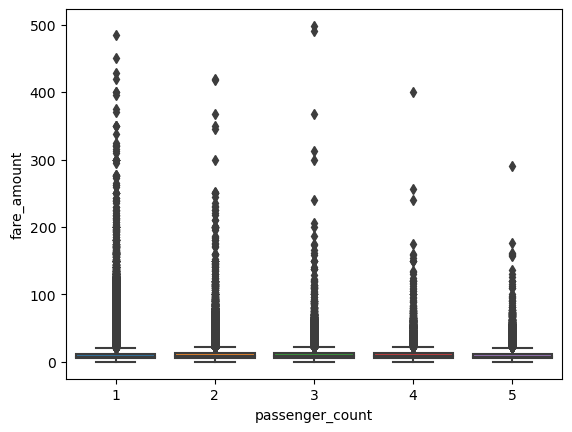

In [21]:
sns.boxplot(x="passenger_count", y="fare_amount", data=df)

# Demo 3: Adding rich features 

cuDF provides standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [22]:
## Ashwin: Can we explain snakeviz and remind to install it
%load_ext snakeviz

In [23]:
%%time

def add_pickup_and_dropoff_coordinates(df):
    taxi_zones = pd.read_csv("taxi_zones.csv")
    
    df['trip_index'] = range(len(df))
    
    ## Ashwin, can we filter to remove missing locations
    pickup_merged = df.merge(taxi_zones, left_on='pickup_location', right_on='LocationID', how='inner')
    dropoff_merged = df.merge(taxi_zones, left_on='dropoff_location', right_on='LocationID', how='inner')
    pickup_merged.reset_index(drop=True)
    dropoff_merged.reset_index(drop=True)
    df['pickup_latitude'] = pickup_merged['y']
    df['pickup_longitude'] = pickup_merged['x']
    df['dropoff_latitude'] = dropoff_merged['y']
    df['dropoff_longitude'] = dropoff_merged['x']
    
    ## Ashwin, shouldn't my inner join above take care of this?
    ## Also, do we need the helper function twice?
    df = df.dropna()

    return df

df = add_pickup_and_dropoff_coordinates(df)
display(df)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,trip_index,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0,0,40.773633,-73.981532,40.782478,-73.965554
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0,1,40.773633,-73.981532,40.782478,-73.965554
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1,2,40.773633,-73.981532,40.782478,-73.965554
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1,3,40.773633,-73.981532,40.782478,-73.965554
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0,-1.0,1,4,40.773633,-73.981532,40.782478,-73.965554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201185,2021-01-29 20:46:53,2021-01-29 20:52:21,5,0.63,1,142,142,5.0,-1.0,1,1145052,40.672090,-73.773036,40.652137,-73.990235
1201186,2021-01-29 20:32:53,2021-01-29 20:44:02,2,2.44,1,166,142,11.0,-1.0,1,1145053,40.672090,-73.773036,40.652137,-73.990235
1201187,2021-01-29 20:37:18,2021-01-29 20:46:12,2,1.90,1,170,249,8.5,-1.0,1,1145054,40.672090,-73.773036,40.652137,-73.990235
1201188,2021-01-29 20:48:24,2021-01-29 20:58:55,2,1.90,1,249,170,9.5,-1.0,1,1145055,40.672090,-73.773036,40.652137,-73.990235


CPU times: user 636 ms, sys: 207 ms, total: 843 ms
Wall time: 833 ms


In [24]:
%%time

def add_pickup_and_dropoff_coordinates(df):
    taxi_zones = cudf.read_csv("taxi_zones.csv")
    
    df['trip_index'] = range(len(df))
    pickup_merged = df.merge(taxi_zones, left_on='pickup_location', right_on='LocationID', how='inner')
    dropoff_merged = df.merge(taxi_zones, left_on='dropoff_location', right_on='LocationID', how='inner')
    pickup_merged = pickup_merged.sort_values("trip_index").reset_index(drop=True)
    dropoff_merged = dropoff_merged.sort_values("trip_index").reset_index(drop=True)
    df['pickup_latitude'] = pickup_merged['y']
    df['pickup_longitude'] = pickup_merged['x']
    df['dropoff_latitude'] = dropoff_merged['y']
    df['dropoff_longitude'] = dropoff_merged['x']
    
    ## Ashwin, shouldn't my inner join above take care of this?
    df = df.dropna()

    return df

gdf = add_pickup_and_dropoff_coordinates(gdf)
gdf

CPU times: user 218 ms, sys: 52.1 ms, total: 270 ms
Wall time: 282 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,trip_index,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0,0,40.773633,-73.981532,40.782478,-73.965554
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0,1,40.791705,-73.973049,40.797962,-73.968168
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1,2,40.646985,-73.786533,40.620924,-73.956825
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1,3,40.731821,-73.976598,40.748428,-73.999917
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0,-1.0,1,4,40.721432,-73.847669,40.723995,-73.902330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201185,2021-01-29 20:46:53,2021-01-29 20:52:21,5,0.63,1,142,142,5.0,-1.0,1,1145052,40.797962,-73.968168,40.801169,-73.937346
1201186,2021-01-29 20:32:53,2021-01-29 20:44:02,2,2.44,1,166,142,11.0,-1.0,1,1145053,40.740337,-73.990458,40.766948,-73.959635
1201187,2021-01-29 20:37:18,2021-01-29 20:46:12,2,1.90,1,170,249,8.5,-1.0,1,1145054,40.727620,-73.985937,40.768615,-73.965635
1201188,2021-01-29 20:48:24,2021-01-29 20:58:55,2,1.90,1,249,170,9.5,-1.0,1,1145055,40.740337,-73.990458,40.748428,-73.999917


In [25]:
def add_datetime_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df    

In [26]:
%%time

# actually add the features
df = add_datetime_features(df)

CPU times: user 413 ms, sys: 17.9 ms, total: 431 ms
Wall time: 424 ms


In [27]:
%%time

# actually add the features
gdf = add_datetime_features(gdf)
gdf

CPU times: user 2.14 ms, sys: 16.1 ms, total: 18.2 ms
Wall time: 15.7 ms


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,trip_index,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend
0,1,2.10,1,142,43,8.0,-1.0,0,0,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0
1,1,0.20,1,238,151,3.0,-1.0,0,1,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0
2,1,14.70,1,132,165,42.0,-1.0,1,2,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0
4,1,4.94,1,68,33,16.5,-1.0,1,3,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0
5,1,1.60,1,224,68,8.0,-1.0,1,4,40.721432,-73.847669,40.723995,-73.902330,0,2021,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201185,5,0.63,1,142,142,5.0,-1.0,1,1145052,40.797962,-73.968168,40.801169,-73.937346,20,2021,1,29,4,0
1201186,2,2.44,1,166,142,11.0,-1.0,1,1145053,40.740337,-73.990458,40.766948,-73.959635,20,2021,1,29,4,0
1201187,2,1.90,1,170,249,8.5,-1.0,1,1145054,40.727620,-73.985937,40.768615,-73.965635,20,2021,1,29,4,0
1201188,2,1.90,1,249,170,9.5,-1.0,1,1145055,40.740337,-73.990458,40.748428,-73.999917,20,2021,1,29,4,0


## cuDF version with UDF

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

In [28]:
%%time

from math import asin, cos, pi, sin, sqrt

def haversine_distance_kernel(row):
    x_1, y_1, x_2, y_2 = (
        row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]
    )
    x_1 = pi/180 * x_1
    y_1 = pi/180 * y_1
    x_2 = pi/180 * x_2
    y_2 = pi/180 * y_2

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2

    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
        
    return c * r

df["h_distance"] = df.apply(haversine_distance_kernel, axis=1)
df.head()

CPU times: user 12.2 s, sys: 151 ms, total: 12.4 s
Wall time: 12.3 s


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,trip_index,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1,2.10,1,142,43,8.0,-1.0,0,0,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1,0.20,1,238,151,3.0,-1.0,0,1,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
2,1,14.70,1,132,165,42.0,-1.0,1,2,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
4,1,4.94,1,68,33,16.5,-1.0,1,3,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
5,1,1.60,1,224,68,8.0,-1.0,1,4,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569


In [29]:
%%time


gdf["h_distance"] = gdf.apply(haversine_distance_kernel, axis=1)
gdf.head()

CPU times: user 2.49 s, sys: 15.3 ms, total: 2.5 s
Wall time: 2.48 s


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,trip_index,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1,2.10,1,142,43,8.0,-1.0,0,0,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1,0.20,1,238,151,3.0,-1.0,0,1,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0,0.808003
2,1,14.70,1,132,165,42.0,-1.0,1,2,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0,14.659199
4,1,4.94,1,68,33,16.5,-1.0,1,3,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0,2.696283
5,1,1.60,1,224,68,8.0,-1.0,1,4,40.721432,-73.847669,40.723995,-73.902330,0,2021,1,1,4,0,4.615133


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9).


In [ ]:
# TODO: Print summary stats from "taxi_gdf"

# Section 3: Exploratory Analysis and Machine Learning

Let's say we're studying consumer behavior on behalf of the taxi commission. Are there a couple of clear "types" of rides that come up again and again? What are some of the key patterns we see in the data? Can we reliably predict some elements of user behavior?

Let's just do this on GPU, because it's faster and the code only differs by using `cuml.` instead of `sklearn.`

In [33]:
%matplotlib inline

In [34]:
from matplotlib import pyplot as plt

In [35]:
gdf.head()

,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,trip_index,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,hour,year,month,day,day_of_week,is_weekend,h_distance
0,1,2.10,1,142,43,8.0,-1.0,0,0,40.773633,-73.981532,40.782478,-73.965554,0,2021,1,1,4,0,1.666569
1,1,0.20,1,238,151,3.0,-1.0,0,1,40.791705,-73.973049,40.797962,-73.968168,0,2021,1,1,4,0,0.808003
2,1,14.70,1,132,165,42.0,-1.0,1,2,40.646985,-73.786533,40.620924,-73.956825,0,2021,1,1,4,0,14.659199
4,1,4.94,1,68,33,16.5,-1.0,1,3,40.731821,-73.976598,40.748428,-73.999917,0,2021,1,1,4,0,2.696283
5,1,1.60,1,224,68,8.0,-1.0,1,4,40.721432,-73.847669,40.723995,-73.902330,0,2021,1,1,4,0,4.615133


In [36]:
%%time

# TODO: use cuML on GPU to fit KMeans with 5 clusters

gdf_standardized = cuml.preprocessing.RobustScaler().fit_transform(gdf)
cu_kmeans = cuml.cluster.KMeans(n_clusters=5)
clusters_gpu = cu_kmeans.fit_predict(gdf_standardized)

../../thread/thread_load.cuh(36): warning: cuda.h: [jitify] File not found
../../thread/thread_store.cuh(36): warning: cuda.h: [jitify] File not found
CPU times: user 11.7 s, sys: 243 ms, total: 11.9 s
Wall time: 12 s


In [37]:
clusters_gpu.value_counts()

0    944965
4    163144
2     35573
3      1360
1        15
dtype: int32

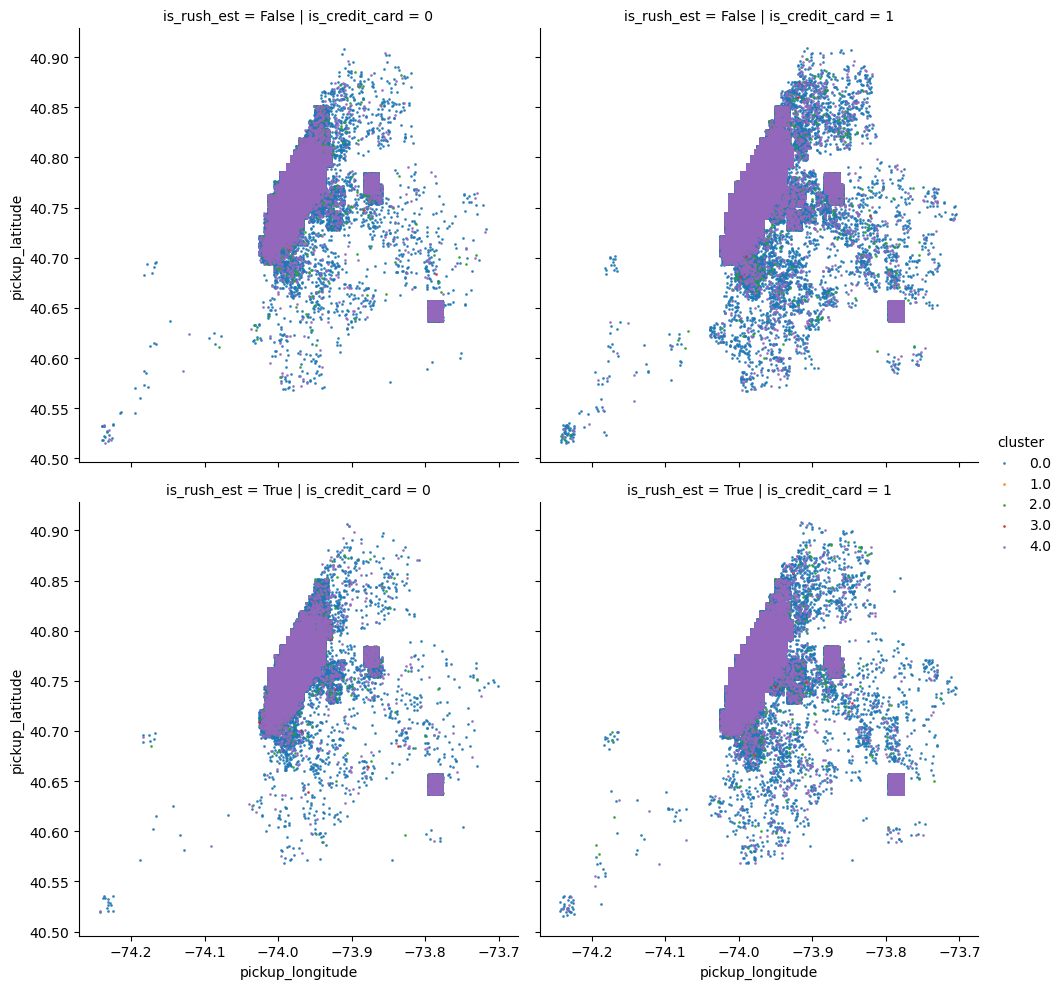

In [38]:
# Add a few interesting variables to help summarize the data
gdf_plot = gdf.copy()
gdf_plot["cluster"] = clusters_gpu
gdf_plot["short_trip"] = gdf_plot["trip_distance"] < 1.01 # About the 25th percentile
gdf_plot["is_rush_est"] = ((gdf_plot.hour >= 10) & (gdf_plot.hour <= 14)) | \
                                ((gdf_plot.hour >= 21) & (gdf_plot.hour <= 24))

# actually do the plot
sns.lmplot(data=gdf_plot.to_pandas(), x="pickup_longitude", y="pickup_latitude", x_jitter=0.01, y_jitter=0.01,
           hue="cluster", col="is_credit_card", row="is_rush_est", fit_reg=False, scatter_kws={"s": 1})

In [39]:
## DRAFT - try umap

gdf_sample = gdf.sample(50000).reset_index()

umap = cuml.manifold.UMAP() 
umap_out = umap.fit_transform(
     cuml.preprocessing.RobustScaler().fit_transform(gdf_sample))

gdf_sample["umap_x"] = umap_out.iloc[:,0]
gdf_sample["umap_y"] = umap_out.iloc[:,1]

In [40]:
import hvplot.cudf
import holoviews as hv

# generate hvplot points chart using cudf DataFrame
gdf_sample.hvplot.scatter(x="umap_x", y="umap_y", by=["is_weekend", "is_credit_card"], s=0.1,
                          subplots=False, hover_cols="all").opts(
    title="Scatter Plot", width=500, height=500
)

ModuleNotFoundError: No module named 'hvplot'

In [41]:
# explorer = hvplot.explorer(gdf_sample)
# explorer.param.set_param(kind='scatter', x='umap_x', y="umap_y")
# explorer

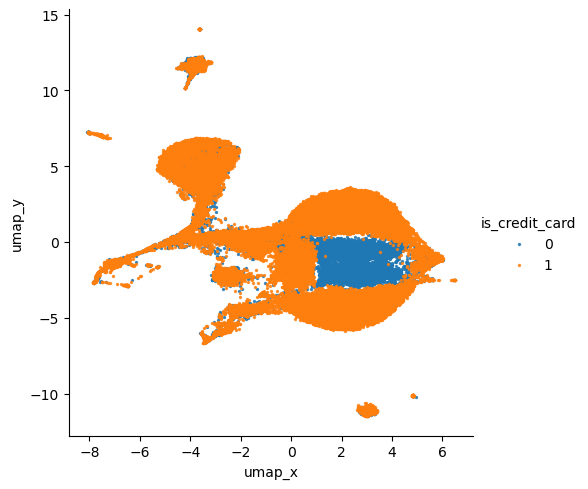

In [42]:
sns.lmplot(data=gdf_sample.to_pandas(), x="umap_x", y="umap_y",
           hue="is_credit_card", fit_reg=False, scatter_kws={"s": 2})

# Build a supervised model to predict payment form

Let's imagine you're a taxi operator trying to understand consumer payment behavior. What types of rides will be paid by credit card and what types via cash? Let's build a predictive model to help us understand.

## Start by splitting training and test data.

We'll want to know how accurate our model is, so let's start by splitting the dataset into "train" and "test" subsets randomly.

In [43]:
%time

# First let's split using Pandas and scikit-learn
import sklearn

y_df = df["is_credit_card"]
X_df = df.drop(columns="is_credit_card")

# Split our dataframes
X_train_df, X_test_df, y_train_df, y_test_df = sklearn.model_selection.train_test_split(X_df, y_df)

# Create array versions of these dataframes
X_train_np, X_test_np = (X_train_df.to_numpy(np.float32), X_test_df.to_numpy(np.float32))
y_train_np, y_test_np = (y_train_df.to_numpy(np.float32), y_test_df.to_numpy(np.float32))

len(X_train_df)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16.5 µs


858792

When we think of ML, we often think of running large predictive models. But scikit-learn also provides a huge toolbox of utilities like preprocessing, data splitting, and more that are essential for ML practitioners. cuML contains GPU-based analogues of these utilities so that your data does not need to take a round trip back to CPU just to partition it.

In [44]:
%%time

# Now do the same on GPU

y_gdf = gdf["is_credit_card"]
X_gdf = gdf.drop(columns="is_credit_card")

# Split our dataframes
X_train_gdf, X_test_gdf, y_train_gdf, y_test_gdf = sklearn.model_selection.train_test_split(X_gdf, y_gdf)

# Create array versions of these dataframes
X_train_gpu, X_test_gpu = (X_train_gdf.to_cupy(np.float32), X_test_gdf.to_cupy(np.float32))
y_train_gpu, y_test_gpu = (y_train_gdf.to_cupy(np.float32), y_test_gdf.to_cupy(np.float32))

len(X_train_gdf)

CPU times: user 927 ms, sys: 30.9 ms, total: 958 ms
Wall time: 960 ms


858792

In [45]:
X_gdf.columns

Index(['passenger_count', 'trip_distance', 'rate_code', 'pickup_location',
       'dropoff_location', 'fare_amount', 'airport_fee', 'trip_index',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'hour', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'h_distance'],
      dtype='object')

### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very common but powerful model - a random forest ensemble for classification. Specifically, we want to classify whether the trip was paid for by credit card (the positive class) or not.

In [46]:
from sklearn.ensemble import RandomForestClassifier as skRandomForestClassifier
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier

In [47]:
%%time

# Scikit-learn will parallelize over all CPU cores with n_jobs=-1

sk_model = skRandomForestClassifier(n_estimators=250, n_jobs=-1)
sk_model.fit(X_train_np, y_train_np)

CPU times: user 16min 29s, sys: 4.92 s, total: 16min 34s
Wall time: 1min 25s


RandomForestClassifier(n_estimators=250, n_jobs=-1)

In [48]:
%%time

# TODO: Build a similar model on GPU with cuML

cuml_model = cuRandomForestClassifier(n_estimators=250)
cuml_model.fit(X_train_gpu, y_train_gpu)

CPU times: user 28.1 s, sys: 193 ms, total: 28.3 s
Wall time: 11.7 s


RandomForestClassifier()

In [ ]:
# Let's use the model to predict from the test set and evaluate the predictions' accuracy

rf_predictions = cuml_model.predict(X_test_gpu)

# Compute the probability that the transaction used a credit card, according to our model
rf_probabilities = cuml_model.predict_proba(X_test_gpu)[:,1]

## Just as cuML provides utilities for data preprocessing and splitting, it also provides a
## wide set of GPU-accelerated metrics, like accuracy and AUC score. These are fast and
## ensure you don't need to fall back to CPU for any of your pipeline.
print("Accuracy: ", cuml.metrics.accuracy.accuracy_score(y_test_gpu, rf_predictions))
print("AUC: ", cuml.metrics.roc_auc_score(y_test_gpu, rf_probabilities))

sns.kdeplot(x=rf_probabilities.get(), hue=y_test_gpu.get())

In [ ]:
## XXX Drop this before final - just for debugging

featimp = pd.DataFrame({
    "feat": X_df.columns,
    "imp": sk_model.feature_importances_})
featimp.sort_values("imp")